# For all testing images


In [9]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import os
from pathlib import Path

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports successful!")

✅ Imports successful!


In [10]:
# 1. Load the original dataset (to get image paths)
dataset_path = "../data/measurebench/real_world/real_world.json"

if os.path.exists(dataset_path):
    with open(dataset_path, 'r') as f:
        dataset = json.load(f)
    # Create mapping: question_id -> image_path
    id_to_image = {item['question_id']: item['image_path'] for item in dataset}
    print(f"✅ Loaded dataset with {len(id_to_image)} image paths")
else:
    print(f"❌ Error: Dataset not found at {dataset_path}")
    id_to_image = {}

# 2. Load Prediction Files
def load_predictions(prediction_file):
    with open(prediction_file, 'r') as f:
        return json.load(f)

results_dir = Path("results")
prediction_files = list(results_dir.glob("*_predictions.json"))

all_predictions = {}
print(f"\nFound {len(prediction_files)} prediction files:")

for f in prediction_files:
    model_name = f.stem.replace('_predictions', '')
    all_predictions[model_name] = load_predictions(f)
    print(f"  - {model_name}: {len(all_predictions[model_name])} predictions loaded")

✅ Loaded dataset with 1272 image paths

Found 5 prediction files:
  - gemini-2.0-flash-exp: 5 predictions loaded
  - gemini-2.5-flash: 295 predictions loaded
  - gemini-2.5-pro: 2 predictions loaded
  - gemini-3-pro-preview: 2 predictions loaded
  - gpt-4o: 2 predictions loaded


In [13]:
def calculate_metrics(predictions):
    """Calculate strict accuracy (N/A counts as wrong)"""
    total = len(predictions)
    if total == 0: return {}
    
    value_correct = 0
    unit_correct = 0
    both_correct = 0
    no_answer = 0
    
    for pred in predictions:
        pred_value = pred.get('predicted_value')
        pred_unit = pred.get('predicted_unit')
        gt = pred.get('ground_truth', {})
        gt_interval = gt.get('interval', [None, None])
        gt_unit = gt.get('unit')
        
        if pred_value is None:
            no_answer += 1
            continue
            
        # Check Value
        val_ok = False
        if gt_interval and gt_interval[0] is not None:
            try:
                # FIX: Convert ground truth strings to floats
                gt_min = float(gt_interval[0])
                gt_max = float(gt_interval[1])
                
                if gt_min <= pred_value <= gt_max:
                    val_ok = True
                    value_correct += 1
            except (ValueError, TypeError):
                # If conversion fails, count as wrong
                val_ok = False
        
        # Check Unit
        unit_ok = False
        if pred_unit and gt_unit:
            if pred_unit.lower() == gt_unit.lower():
                unit_ok = True
                unit_correct += 1
        elif not gt_unit: # If no unit required
            unit_ok = True
            unit_correct += 1
            
        # Check Both
        if val_ok and unit_ok:
            both_correct += 1
    
    return {
        'Total': total,
        'No Answer': no_answer,
        'Value Acc': value_correct / total,
        'Unit Acc': unit_correct / total,
        'Overall Acc': both_correct / total
    }

# Display Table
print("="*60)
print("STRICT METRICS (N/A = Wrong)")
print("="*60)
summary = {m: calculate_metrics(p) for m, p in all_predictions.items()}
print(pd.DataFrame(summary).T.to_string())

STRICT METRICS (N/A = Wrong)
                      Total  No Answer  Value Acc  Unit Acc  Overall Acc
gemini-2.0-flash-exp    5.0        5.0   0.000000  0.000000     0.000000
gemini-2.5-flash      295.0       76.0   0.047458  0.742373     0.047458
gemini-2.5-pro          2.0        1.0   0.000000  0.500000     0.000000
gemini-3-pro-preview    2.0        2.0   0.000000  0.000000     0.000000
gpt-4o                  2.0        2.0   0.000000  0.000000     0.000000


In [14]:
def calculate_effective_metrics(predictions):
    """Calculate accuracy ONLY for answered questions"""
    # Filter out N/A
    valid_preds = [p for p in predictions if p.get('predicted_value') is not None]
    
    total_original = len(predictions)
    total_valid = len(valid_preds)
    
    if total_valid == 0: return {'Status': 'No valid predictions'}
    
    value_correct = 0
    both_correct = 0
    
    for pred in valid_preds:
        pred_value = pred.get('predicted_value')
        pred_unit = pred.get('predicted_unit')
        gt = pred.get('ground_truth', {})
        gt_interval = gt.get('interval', [None, None])
        gt_unit = gt.get('unit')
        
        # Check Value
        val_ok = False
        if gt_interval and gt_interval[0] is not None:
            try:
                # FIX: Convert ground truth strings to floats
                gt_min = float(gt_interval[0])
                gt_max = float(gt_interval[1])
                
                if gt_min <= pred_value <= gt_max:
                    val_ok = True
                    value_correct += 1
            except (ValueError, TypeError):
                val_ok = False
        
        # Check Unit
        unit_ok = True
        if gt_unit:
            if not pred_unit or pred_unit.lower() != gt_unit.lower():
                unit_ok = False
        
        if val_ok and unit_ok:
            both_correct += 1
            
    return {
        'Total Images': total_original,
        'Answered': total_valid,
        'Response Rate': f"{(total_valid/total_original)*100:.1f}%",
        'Value Accuracy (Valid Only)': f"{(value_correct/total_valid)*100:.1f}%",
        'Overall Accuracy (Valid Only)': f"{(both_correct/total_valid)*100:.1f}%"
    }

print("="*80)
print("EFFECTIVE ACCURACY (Excluding N/A results)")
print("="*80)
eff_summary = [dict({'Model': m}, **calculate_effective_metrics(p)) for m, p in all_predictions.items()]
print(pd.DataFrame(eff_summary).to_string(index=False))

EFFECTIVE ACCURACY (Excluding N/A results)
               Model               Status  Total Images  Answered Response Rate Value Accuracy (Valid Only) Overall Accuracy (Valid Only)
gemini-2.0-flash-exp No valid predictions           NaN       NaN           NaN                         NaN                           NaN
    gemini-2.5-flash                  NaN         295.0     219.0         74.2%                        6.4%                          6.4%
      gemini-2.5-pro                  NaN           2.0       1.0         50.0%                        0.0%                          0.0%
gemini-3-pro-preview No valid predictions           NaN       NaN           NaN                         NaN                           NaN
              gpt-4o No valid predictions           NaN       NaN           NaN                         NaN                           NaN


✅ Libraries imported successfully
✅ Loaded 1272 image paths from dataset.
✅ Loaded gemini-2.0-flash-exp: 5 predictions
✅ Loaded gemini-2.5-flash: 295 predictions
✅ Loaded gemini-2.5-pro: 2 predictions
✅ Loaded gemini-3-pro-preview: 2 predictions
✅ Loaded gpt-4o: 2 predictions

ADVANCED STATISTICAL ANALYSIS
           Model  Count  MRE (Mean Rel Error)  Median Rel Error  Acc (<10% Error)  Strict Acc (In Interval)
gemini-2.5-flash    121                1.2271            0.7123           22.3140                   11.5702
  gemini-2.5-pro      1                0.8000            0.8000            0.0000                    0.0000


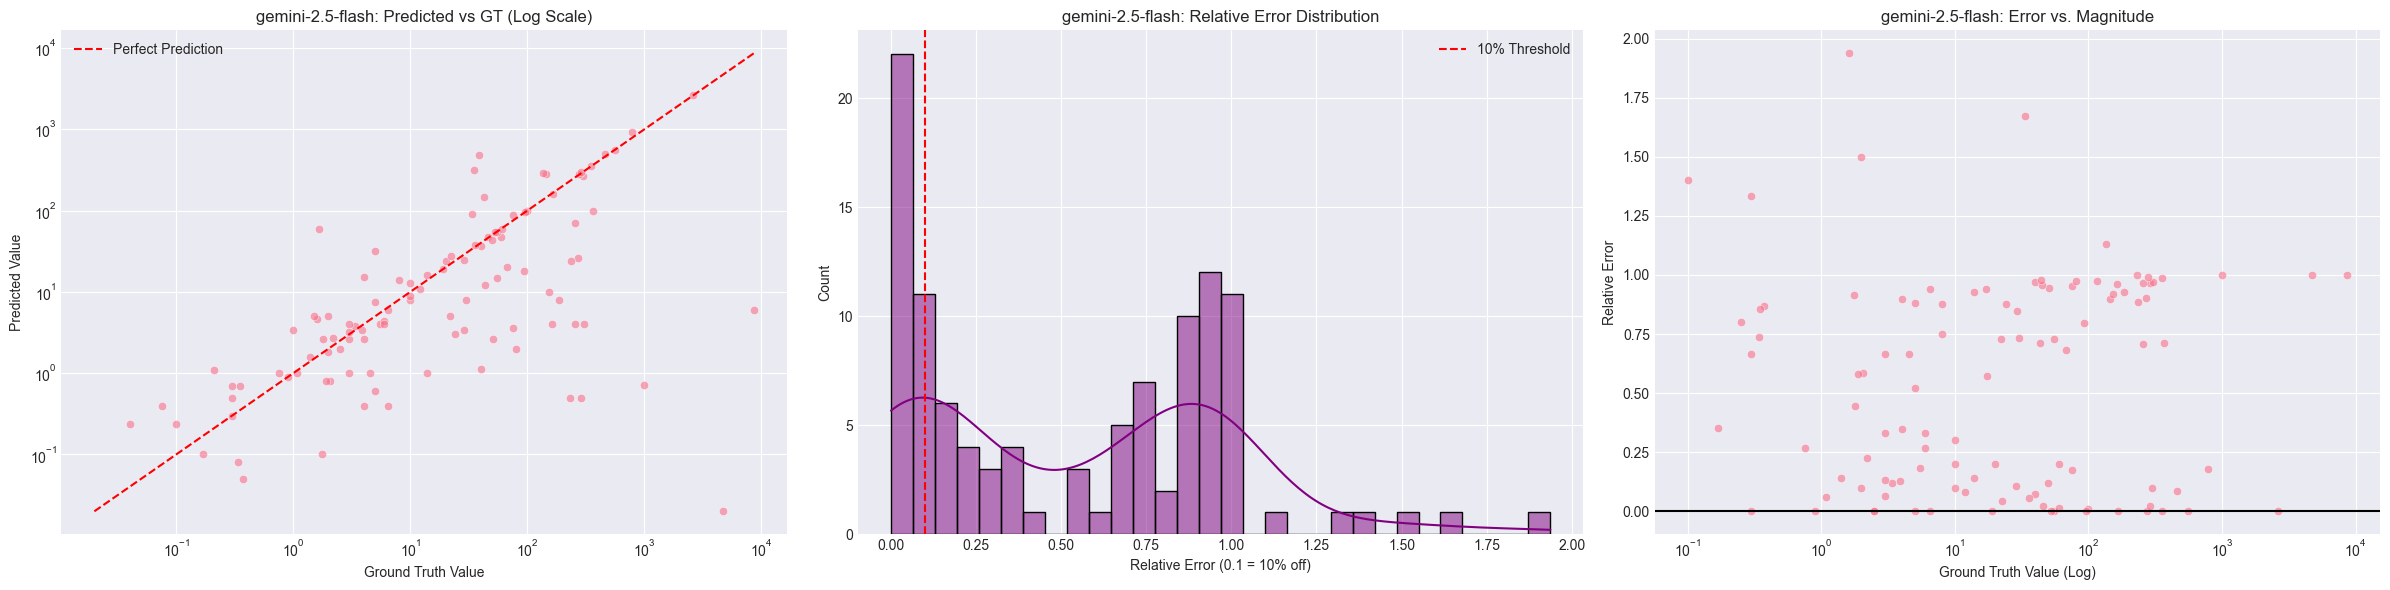

In [5]:
# %% [markdown]
# # Advanced Evaluation & Visualization
# This notebook calculates continuous error metrics (distance from ground truth interval)
# and visualizes specific predictions with the image and VLM reasoning.

# %%
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

# %%
# 1. Load Data
# Adjust paths based on file location relative to this notebook
dataset_path = "../data/measurebench/real_world/real_world.json"
results_dir = Path("results")

# Load Image Mapping
id_to_image = {}
if os.path.exists(dataset_path):
    with open(dataset_path, 'r') as f:
        dataset = json.load(f)
    id_to_image = {item['question_id']: item['image_path'] for item in dataset}
    print(f"✅ Loaded {len(id_to_image)} image paths from dataset.")
else:
    print(f"❌ Warning: Dataset not found at {dataset_path}")

# Load Predictions
all_predictions = {}
prediction_files = list(results_dir.glob("*_predictions.json"))

if not prediction_files:
    print("❌ No prediction files found in 'results/' directory.")
else:
    for f in prediction_files:
        model_name = f.stem.replace('_predictions', '')
        with open(f, 'r') as file:
            all_predictions[model_name] = json.load(file)
        print(f"✅ Loaded {model_name}: {len(all_predictions[model_name])} predictions")

# ...existing code...
# 2. Advanced Statistical Analysis
def analyze_model_performance(predictions, model_name):
    """
    Performs comprehensive regression analysis:
    - Absolute Error
    - Relative Error (handling scale differences)
    - Accuracy at different tolerance levels (within 5%, 10%, etc.)
    """
    data = []
    
    for pred in predictions:
        p_val = pred.get('predicted_value')
        gt = pred.get('ground_truth', {})
        interval = gt.get('interval', [None, None])
        
        if p_val is None or interval is None or interval[0] is None:
            continue
            
        try:
            gt_min = float(interval[0])
            gt_max = float(interval[1])
            gt_mid = (gt_min + gt_max) / 2.0
            
            # 1. Absolute Error (Distance to interval)
            if gt_min <= p_val <= gt_max:
                abs_err = 0.0
            elif p_val < gt_min:
                abs_err = gt_min - p_val
            else:
                abs_err = p_val - gt_max
            
            # 2. Relative Error (Normalized by ground truth magnitude)
            # Avoid division by zero
            denominator = abs(gt_mid) if abs(gt_mid) > 1e-6 else 1.0
            rel_err = abs_err / denominator
            
            data.append({
                'id': pred['question_id'],
                'gt_mid': gt_mid,
                'pred': p_val,
                'abs_err': abs_err,
                'rel_err': rel_err,
                'is_correct': abs_err == 0
            })
                
        except (ValueError, TypeError):
            continue
    
    if not data:
        return None, None

    df = pd.DataFrame(data)
    
    # Calculate Aggregate Metrics
    metrics = {
        'Model': model_name,
        'Count': len(df),
        'MAE': df['abs_err'].mean(),
        'Median AE': df['abs_err'].median(),
        'MRE (Mean Rel Error)': df['rel_err'].mean(),
        'Median Rel Error': df['rel_err'].median(),
        'Acc (<5% Error)': (df['rel_err'] < 0.05).mean() * 100,
        'Acc (<10% Error)': (df['rel_err'] < 0.10).mean() * 100,
        'Strict Acc (In Interval)': df['is_correct'].mean() * 100
    }
    
    return df, metrics

# --- Run Analysis for All Models ---
print("\n" + "="*80)
print("ADVANCED STATISTICAL ANALYSIS")
print("="*80)

model_metrics = []
model_dfs = {}

for model, preds in all_predictions.items():
    df, met = analyze_model_performance(preds, model)
    if met:
        model_metrics.append(met)
        model_dfs[model] = df

# Display Metrics Table
if model_metrics:
    metrics_df = pd.DataFrame(model_metrics)
    # Format for readability
    display_cols = ['Model', 'Count', 'MRE (Mean Rel Error)', 'Median Rel Error', 'Acc (<10% Error)', 'Strict Acc (In Interval)']
    print(metrics_df[display_cols].to_string(index=False, float_format="%.4f"))
else:
    print("No valid numeric data found.")

# --- Visualizations ---

# 1. Scatter Plot: Predicted vs Ground Truth (Log Scale often helps with wide ranges)
if model_dfs:
    # Pick the model with most data for visualization
    best_model = max(model_dfs, key=lambda k: len(model_dfs[k]))
    df_viz = model_dfs[best_model]
    
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    # Plot A: Predicted vs GT (Log Scale)
    ax = axes[0]
    # Filter out zeros/negatives for log plot safety
    plot_data = df_viz[(df_viz['gt_mid'] > 0) & (df_viz['pred'] > 0)]
    
    sns.scatterplot(data=plot_data, x='gt_mid', y='pred', alpha=0.6, ax=ax)
    
    # Diagonal line
    min_val = min(plot_data['gt_mid'].min(), plot_data['pred'].min())
    max_val = max(plot_data['gt_mid'].max(), plot_data['pred'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'{best_model}: Predicted vs GT (Log Scale)')
    ax.set_xlabel('Ground Truth Value')
    ax.set_ylabel('Predicted Value')
    ax.legend()
    
    # Plot B: Relative Error Distribution
    ax = axes[1]
    # Clip extreme outliers for better histogram visibility (e.g., > 100% error)
    sns.histplot(data=df_viz[df_viz['rel_err'] < 2.0], x='rel_err', bins=30, kde=True, ax=ax, color='purple')
    ax.set_title(f'{best_model}: Relative Error Distribution')
    ax.set_xlabel('Relative Error (0.1 = 10% off)')
    ax.axvline(0.1, color='r', linestyle='--', label='10% Threshold')
    ax.legend()
    
    # Plot C: Bland-Altman Style (Error vs Magnitude)
    # Helps see if error gets worse for larger values
    ax = axes[2]
    sns.scatterplot(data=df_viz[df_viz['rel_err'] < 2.0], x='gt_mid', y='rel_err', alpha=0.6, ax=ax)
    ax.set_xscale('log')
    ax.set_title(f'{best_model}: Error vs. Magnitude')
    ax.set_xlabel('Ground Truth Value (Log)')
    ax.set_ylabel('Relative Error')
    ax.axhline(0, color='black', linestyle='-')
    
    plt.tight_layout()
    plt.show()

# 3. Visualization Function (Updated)
def visualize_prediction_detailed(image_id, model_name):
    """
    Visualizes the image, the prompt, the full model response, and the evaluation.
    """
    if model_name not in all_predictions:
        print(f"❌ Model {model_name} not found.")
        return

    # Find prediction
    pred = next((p for p in all_predictions[model_name] if p['question_id'] == image_id), None)
    if not pred:
        print(f"❌ Prediction for {image_id} not found.")
        return

    # Extract Data
    pred_val = pred.get('predicted_value')
    pred_unit = pred.get('predicted_unit')
    gt_interval = pred.get('ground_truth', {}).get('interval', [None, None])
    gt_unit = pred.get('ground_truth', {}).get('unit', '')
    question = pred.get('question', '')
    full_response = pred.get('prediction', '') 

    # Setup Plot
    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1], wspace=0.1)
    
    # --- Image Panel ---
    ax_img = fig.add_subplot(gs[0])
    img_path = id_to_image.get(image_id)
    
    if img_path and os.path.exists(img_path):
        img = Image.open(img_path)
        ax_img.imshow(img)
        
        # Overlay Text Boxes
        status = "UNKNOWN"
        color = "gray"
        
        # Check correctness
        if pred_val is not None and gt_interval[0] is not None:
            try:
                if float(gt_interval[0]) <= pred_val <= float(gt_interval[1]):
                    status = "CORRECT"
                    color = "lightgreen"
                else:
                    status = "INCORRECT"
                    color = "salmon"
            except: pass
            
        # Draw boxes - Handle None values gracefully for display
        disp_val = str(pred_val) if pred_val is not None else "N/A"
        disp_unit = str(pred_unit) if pred_unit is not None else ""
        
        ax_img.text(20, 40, f"Pred: {disp_val} {disp_unit}", 
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.9), 
                   fontsize=14, fontweight='bold')
        
        ax_img.text(20, 90, f"GT: {gt_interval} {gt_unit}", 
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9), 
                   fontsize=14, fontweight='bold')
        
        ax_img.text(img.size[0]//2, img.size[1]-50, status, 
                   bbox=dict(boxstyle='round,pad=0.8', facecolor=color, alpha=1.0, edgecolor='black'), 
                   fontsize=20, fontweight='bold', ha='center', color='white')
    else:
        ax_img.text(0.5, 0.5, "Image Not Found", ha='center')
        
    ax_img.axis('off')
    ax_img.set_title(f"Image ID: {image_id}", fontsize=16, fontweight='bold')

    # --- Text/Details Panel ---
    ax_txt = fig.add_subplot(gs[1])
    ax_txt.axis('off')
    
    # Format text
    display_response = full_response[:1000] + "..." if len(full_response) > 1000 else full_response
    
    info_text = f"""
--------------------------------------------------
❓ QUESTION / PROMPT
--------------------------------------------------
{question}

--------------------------------------------------
🤖 MODEL RESPONSE ({model_name})
--------------------------------------------------
{display_response}

--------------------------------------------------
📊 EVALUATION
--------------------------------------------------
Predicted Value : {pred_val}
Predicted Unit  : {pred_unit}
Ground Truth    : {gt_interval} {gt_unit}
    """
    
    ax_txt.text(0.05, 0.95, info_text, va='top', fontsize=10, family='monospace', 
                bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

In [18]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import numpy as np

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports successful!")

✅ Imports successful!


In [21]:
# 1. Load the original dataset (to get image paths)
# Adjust this path if your notebook is in a different folder relative to data
dataset_path = "../data/measurebench/real_world/real_world.json"

id_to_image = {}
if os.path.exists(dataset_path):
    with open(dataset_path, 'r') as f:
        dataset = json.load(f)
    # Create mapping: question_id -> image_path
    id_to_image = {item['question_id']: item['image_path'] for item in dataset}
    print(f"✅ Loaded dataset with {len(id_to_image)} image paths")
else:
    print(f"❌ Error: Dataset not found at {dataset_path}")

# 2. Load Prediction Files
def load_predictions_from_file(prediction_file):
    with open(prediction_file, 'r') as f:
        return json.load(f)

results_dir = Path("results")
prediction_files = list(results_dir.glob("*_predictions.json"))

all_predictions = {}
print(f"\nFound {len(prediction_files)} prediction files:")

for f in prediction_files:
    # Extract model name from filename (e.g., 'gemini-1.5-flash_predictions.json' -> 'gemini-1.5-flash')
    model_name = f.stem.replace('_predictions', '')
    all_predictions[model_name] = load_predictions_from_file(f)
    print(f"  - {model_name}: {len(all_predictions[model_name])} predictions loaded")

✅ Loaded dataset with 1272 image paths

Found 5 prediction files:
  - gemini-2.0-flash-exp: 5 predictions loaded
  - gemini-2.5-flash: 295 predictions loaded
  - gemini-2.5-pro: 2 predictions loaded
  - gemini-3-pro-preview: 2 predictions loaded
  - gpt-4o: 2 predictions loaded


In [22]:
def visualize_prediction_simple(image_id, model_name):
    """
    Visualizes a single prediction with Image, Prompt, Answer, and Evaluation.
    """
    # 1. Check if model exists
    if model_name not in all_predictions:
        print(f"❌ Model '{model_name}' not found in loaded predictions.")
        print(f"Available models: {list(all_predictions.keys())}")
        return

    # 2. Find the specific prediction for this image_id
    pred = next((p for p in all_predictions[model_name] if p['question_id'] == image_id), None)
    
    if not pred:
        print(f"❌ No prediction found for Image ID: {image_id}")
        return
    
    # 3. Extract Data
    pred_value = pred.get('predicted_value')
    pred_unit = pred.get('predicted_unit', '')
    full_answer = pred.get('prediction', '')
    question = pred.get('question', '')
    
    gt = pred.get('ground_truth', {})
    gt_interval = gt.get('interval', [None, None])
    gt_unit = gt.get('unit', '')
    
    # 4. Load Image
    image_path = id_to_image.get(image_id)
    
    # 5. Setup Plot Layout
    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[2, 1], hspace=0.3, wspace=0.3)
    
    # --- LEFT PANEL: IMAGE ---
    ax_img = fig.add_subplot(gs[:, 0])
    
    if image_path and os.path.exists(image_path):
        try:
            img = Image.open(image_path)
            ax_img.imshow(img)
            ax_img.axis('off')
            
            img_width, img_height = img.size
            
            # Draw Prediction Box (Yellow)
            pred_text = f"PRED: {pred_value} {pred_unit}"
            ax_img.text(20, 40, pred_text, 
                       bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow', edgecolor='black', alpha=0.9),
                       fontsize=14, fontweight='bold', color='black')
            
            # Draw Ground Truth Box (Green)
            if gt_interval and gt_interval[0] is not None:
                gt_text = f"GT: [{gt_interval[0]}, {gt_interval[1]}] {gt_unit}"
                ax_img.text(img_width - 20, 40, gt_text, 
                           bbox=dict(boxstyle='round,pad=0.8', facecolor='#76ff03', edgecolor='black', alpha=0.9),
                           fontsize=14, fontweight='bold', color='black', ha='right')
            
            # Draw Status (Bottom Center)
            if pred_value is not None and gt_interval and gt_interval[0] is not None:
                try:
                    val_ok = float(gt_interval[0]) <= float(pred_value) <= float(gt_interval[1])
                    # Simple unit check (case insensitive)
                    unit_ok = True
                    if gt_unit and pred_unit:
                        unit_ok = pred_unit.lower() == gt_unit.lower()
                    
                    is_correct = val_ok and unit_ok
                    
                    status = "✓ CORRECT" if is_correct else "✗ INCORRECT"
                    color = '#76ff03' if is_correct else '#ff5252'
                    
                    ax_img.text(img_width // 2, img_height - 40, status,
                               bbox=dict(boxstyle='round,pad=1', facecolor=color, edgecolor='black', linewidth=2),
                               fontsize=18, fontweight='bold', color='white', ha='center')
                except (ValueError, TypeError):
                    pass # Skip status if conversion fails
                    
        except Exception as e:
            ax_img.text(0.5, 0.5, f"Error loading image:\n{e}", ha='center')
    else:
        ax_img.axis('off')
        ax_img.text(0.5, 0.5, f"Image not found at:\n{image_path}", ha='center', color='red')
        
    ax_img.set_title(f"Image ID: {image_id}", fontsize=16, fontweight='bold')

    # --- TOP RIGHT: PROMPT & ANSWER ---
    ax_prompt = fig.add_subplot(gs[0, 1])
    ax_prompt.axis('off')
    ax_prompt.set_title("PROMPT & MODEL RESPONSE", fontsize=12, fontweight='bold')
    
    # Truncate long responses for display
    disp_answer = full_answer[:800] + "..." if len(full_answer) > 800 else full_answer
    
    info_text = f"""
📝 QUESTION:
{question}

🤖 MODEL ANSWER:
{disp_answer}
    """
    ax_prompt.text(0, 1, info_text, fontsize=10, family='monospace', va='top',
                   bbox=dict(boxstyle='round', facecolor='#e3f2fd', alpha=0.5))

    # --- BOTTOM RIGHT: EVALUATION DETAILS ---
    ax_eval = fig.add_subplot(gs[1, 1])
    ax_eval.axis('off')
    ax_eval.set_title("EVALUATION METRICS", fontsize=12, fontweight='bold')
    
    eval_text = f"""
Predicted Value : {pred_value}
Predicted Unit  : {pred_unit}
Ground Truth    : {gt_interval} {gt_unit}
    """
    ax_eval.text(0, 1, eval_text, fontsize=11, family='monospace', va='top',
                 bbox=dict(boxstyle='round', facecolor='#f1f8e9', alpha=0.5))

    plt.tight_layout()
    plt.show()

In [23]:
# Select a model and an image ID to visualize
if all_predictions:
    # 1. Pick the first available model automatically
    current_model = list(all_predictions.keys())[0]
    
    # 2. Define the Image ID you want to see
    target_id = 'real_world_0263' 
    
    print(f"🚀 Visualizing ID '{target_id}' using model '{current_model}'...")
    visualize_prediction_simple(target_id, model_name=current_model)
else:
    print("⚠️ No predictions loaded. Please check your 'results' folder.")

🚀 Visualizing ID 'real_world_0263' using model 'gemini-2.0-flash-exp'...
❌ No prediction found for Image ID: real_world_0263


# stop


In [ ]:
# 1. Load the original dataset (to get image paths)
# Adjust this path if your notebook is in a different folder relative to data
dataset_path = "../data/measurebench/real_world/real_world.json"

id_to_image = {}
if os.path.exists(dataset_path):
    with open(dataset_path, 'r') as f:
        dataset = json.load(f)
    # Create mapping: question_id -> image_path
    id_to_image = {item['question_id']: item['image_path'] for item in dataset}
    print(f"✅ Loaded dataset with {len(id_to_image)} image paths")
else:
    print(f"❌ Error: Dataset not found at {dataset_path}")

# 2. Load Prediction Files
def load_predictions_from_file(prediction_file):
    with open(prediction_file, 'r') as f:
        return json.load(f)

results_dir = Path("results")
prediction_files = list(results_dir.glob("*_predictions.json"))

all_predictions = {}
print(f"\nFound {len(prediction_files)} prediction files:")

for f in prediction_files:
    # Extract model name from filename (e.g., 'gemini-1.5-flash_predictions.json' -> 'gemini-1.5-flash')
    model_name = f.stem.replace('_predictions', '')
    all_predictions[model_name] = load_predictions_from_file(f)
    print(f"  - {model_name}: {len(all_predictions[model_name])} predictions loaded")

ADVANCED REGRESSION METRICS (Normalized for Scale)


TypeError: 'NoneType' object is not subscriptable

In [1]:
# %% [markdown]
# # Advanced Evaluation & Visualization
# This notebook calculates continuous error metrics (distance from ground truth interval)
# and visualizes specific predictions with the image and VLM reasoning.

# %%
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

# %%
# 1. Load Data
# Adjust paths based on file location relative to this notebook
dataset_path = "../data/measurebench/real_world/real_world.json"
results_dir = Path("results")

# Load Image Mapping
id_to_image = {}
if os.path.exists(dataset_path):
    with open(dataset_path, 'r') as f:
        dataset = json.load(f)
    id_to_image = {item['question_id']: item['image_path'] for item in dataset}
    print(f"✅ Loaded {len(id_to_image)} image paths from dataset.")
else:
    print(f"❌ Warning: Dataset not found at {dataset_path}")

# Load Predictions
all_predictions = {}
prediction_files = list(results_dir.glob("*_predictions.json"))

if not prediction_files:
    print("❌ No prediction files found in 'results/' directory.")
else:
    for f in prediction_files:
        model_name = f.stem.replace('_predictions', '')
        with open(f, 'r') as file:
            all_predictions[model_name] = json.load(file)
        print(f"✅ Loaded {model_name}: {len(all_predictions[model_name])} predictions")

# %%
# 2. Define Continuous Error Metrics
def calculate_error_metrics(predictions):
    """
    Calculates how far off predictions are from the ground truth interval.
    Error = 0 if inside interval.
    Error = Distance to nearest boundary if outside.
    """
    errors = []
    abs_errors = []
    relative_errors = []
    
    for pred in predictions:
        p_val = pred.get('predicted_value')
        gt = pred.get('ground_truth', {})
        interval = gt.get('interval', [None, None])
        
        if p_val is None or interval[0] is None:
            continue
            
        try:
            gt_min = float(interval[0])
            gt_max = float(interval[1])
            
            # Calculate Error
            # If inside interval, error is 0.
            # If outside, distance to nearest boundary.
            if gt_min <= p_val <= gt_max:
                err = 0.0
            elif p_val < gt_min:
                err = gt_min - p_val # Positive distance
            else:
                err = p_val - gt_max # Positive distance
                
            errors.append(err)
            abs_errors.append(abs(err))
            
            # Relative Error (using midpoint as reference)
            midpoint = (gt_min + gt_max) / 2
            if midpoint != 0:
                rel_err = abs(err) / abs(midpoint)
                relative_errors.append(rel_err)
                
        except (ValueError, TypeError):
            continue
            
    if not errors:
        return {'MAE': 0, 'MSE': 0}
        
    return {
        'Count': len(errors),
        'Mean Absolute Error (MAE)': np.mean(abs_errors),
        'Root Mean Sq Error (RMSE)': np.sqrt(np.mean(np.array(errors)**2)),
        'Max Error': np.max(abs_errors),
        'Mean Relative Error': np.mean(relative_errors) if relative_errors else 0
    }

# Calculate for all models
print("\n" + "="*80)
print("CONTINUOUS ERROR METRICS (Distance from GT Interval)")
print("="*80)

error_summary = []
for model, preds in all_predictions.items():
    metrics = calculate_error_metrics(preds)
    metrics['Model'] = model
    error_summary.append(metrics)

if error_summary:
    df_errors = pd.DataFrame(error_summary)
    # Reorder columns
    cols = ['Model', 'Count', 'Mean Absolute Error (MAE)', 'Root Mean Sq Error (RMSE)', 'Mean Relative Error']
    print(df_errors[cols].to_string(index=False))
else:
    print("No data to analyze.")

# %%
# 3. Visualization Function
def visualize_prediction_detailed(image_id, model_name):
    """
    Visualizes the image, the prompt, the full model response, and the evaluation.
    """
    if model_name not in all_predictions:
        print(f"❌ Model {model_name} not found.")
        return

    # Find prediction
    pred = next((p for p in all_predictions[model_name] if p['question_id'] == image_id), None)
    if not pred:
        print(f"❌ Prediction for {image_id} not found.")
        return

    # Extract Data
    pred_val = pred.get('predicted_value')
    pred_unit = pred.get('predicted_unit', '')
    gt_interval = pred.get('ground_truth', {}).get('interval', [None, None])
    gt_unit = pred.get('ground_truth', {}).get('unit', '')
    question = pred.get('question', '')
    full_response = pred.get('prediction', '') 

    # Setup Plot
    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1], wspace=0.1)
    
    # --- Image Panel ---
    ax_img = fig.add_subplot(gs[0])
    img_path = id_to_image.get(image_id)
    
    if img_path and os.path.exists(img_path):
        img = Image.open(img_path)
        ax_img.imshow(img)
        
        # Overlay Text Boxes
        status = "UNKNOWN"
        color = "gray"
        
        # Check correctness
        if pred_val is not None and gt_interval[0] is not None:
            try:
                if float(gt_interval[0]) <= pred_val <= float(gt_interval[1]):
                    status = "CORRECT"
                    color = "lightgreen"
                else:
                    status = "INCORRECT"
                    color = "salmon"
            except: pass
            
        # Draw boxes
        ax_img.text(20, 40, f"Pred: {pred_val} {pred_unit}", 
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.9), 
                   fontsize=14, fontweight='bold')
        
        ax_img.text(20, 90, f"GT: {gt_interval} {gt_unit}", 
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9), 
                   fontsize=14, fontweight='bold')
        
        ax_img.text(img.size[0]//2, img.size[1]-50, status, 
                   bbox=dict(boxstyle='round,pad=0.8', facecolor=color, alpha=1.0, edgecolor='black'), 
                   fontsize=20, fontweight='bold', ha='center', color='white')
    else:
        ax_img.text(0.5, 0.5, "Image Not Found", ha='center')
        
    ax_img.axis('off')
    ax_img.set_title(f"Image ID: {image_id}", fontsize=16, fontweight='bold')

    # --- Text/Details Panel ---
    ax_txt = fig.add_subplot(gs[1])
    ax_txt.axis('off')
    
    # Format text
    display_response = full_response[:1000] + "..." if len(full_response) > 1000 else full_response
    
    info_text = f"""
--------------------------------------------------
❓ QUESTION / PROMPT
--------------------------------------------------
{question}

--------------------------------------------------
🤖 MODEL RESPONSE ({model_name})
--------------------------------------------------
{display_response}

--------------------------------------------------
📊 EVALUATION
--------------------------------------------------
Predicted Value : {pred_val}
Predicted Unit  : {pred_unit}
Ground Truth    : {gt_interval} {gt_unit}
    """
    
    ax_txt.text(0.05, 0.95, info_text, va='top', fontsize=10, family='monospace', 
                bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# %%
# 4. Run Visualization on a Sample
# Change 'sample_id' to view different images (e.g., 'real_world_0263')
if all_predictions:
    first_model = list(all_predictions.keys())[0]
    
    # Try to find a specific interesting sample, or default to the first one
    target_id = 'real_world_0263'
    
    # Check if target exists in predictions
    exists = any(p['question_id'] == target_id for p in all_predictions[first_model])
    
    if exists:
        sample_id = target_id
    elif len(all_predictions[first_model]) > 0:
        sample_id = all_predictions[first_model][0]['question_id']
    else:
        sample_id = None

    if sample_id:
        print(f"Visualizing {sample_id} for model {first_model}")
        visualize_prediction_detailed(sample_id, first_model)
    else:
        print("No predictions available to visualize.")

✅ Libraries imported successfully
✅ Loaded 1272 image paths from dataset.
✅ Loaded gemini-2.0-flash-exp: 5 predictions
✅ Loaded gemini-2.5-flash: 295 predictions
✅ Loaded gemini-2.5-pro: 2 predictions
✅ Loaded gemini-3-pro-preview: 2 predictions
✅ Loaded gpt-4o: 2 predictions

CONTINUOUS ERROR METRICS (Distance from GT Interval)


TypeError: 'NoneType' object is not subscriptable

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import os
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Imports successful!")

Imports successful!


In [2]:
def load_predictions(prediction_file):
    """Load predictions from JSON file"""
    with open(prediction_file, 'r') as f:
        data = json.load(f)
    return data

# Load available prediction files
results_dir = Path("results")
prediction_files = list(results_dir.glob("*_predictions.json"))

print(f"Found {len(prediction_files)} prediction files:")
for f in prediction_files:
    print(f"  - {f.name}")

# Load all predictions
all_predictions = {}
for pred_file in prediction_files:
    model_name = pred_file.stem.replace('_predictions', '')
    all_predictions[model_name] = load_predictions(pred_file)
    print(f"\nLoaded {len(all_predictions[model_name])} predictions for {model_name}")

Found 5 prediction files:
  - gemini-2.0-flash-exp_predictions.json
  - gemini-2.5-flash_predictions.json
  - gemini-2.5-pro_predictions.json
  - gemini-3-pro-preview_predictions.json
  - gpt-4o_predictions.json

Loaded 5 predictions for gemini-2.0-flash-exp

Loaded 295 predictions for gemini-2.5-flash

Loaded 2 predictions for gemini-2.5-pro

Loaded 2 predictions for gemini-3-pro-preview

Loaded 2 predictions for gpt-4o


In [3]:
# Load the original dataset to get image paths
dataset_path = "../data/measurebench/real_world/real_world.json"
with open(dataset_path, 'r') as f:
    dataset = json.load(f)

# Create mapping from question_id to image_path
id_to_image = {item['question_id']: item['image_path'] for item in dataset}
print(f"Loaded dataset with {len(id_to_image)} image paths")

Loaded dataset with 1272 image paths


C:\Users\User\AppData\Local\Temp\ipykernel_23368\1996284123.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


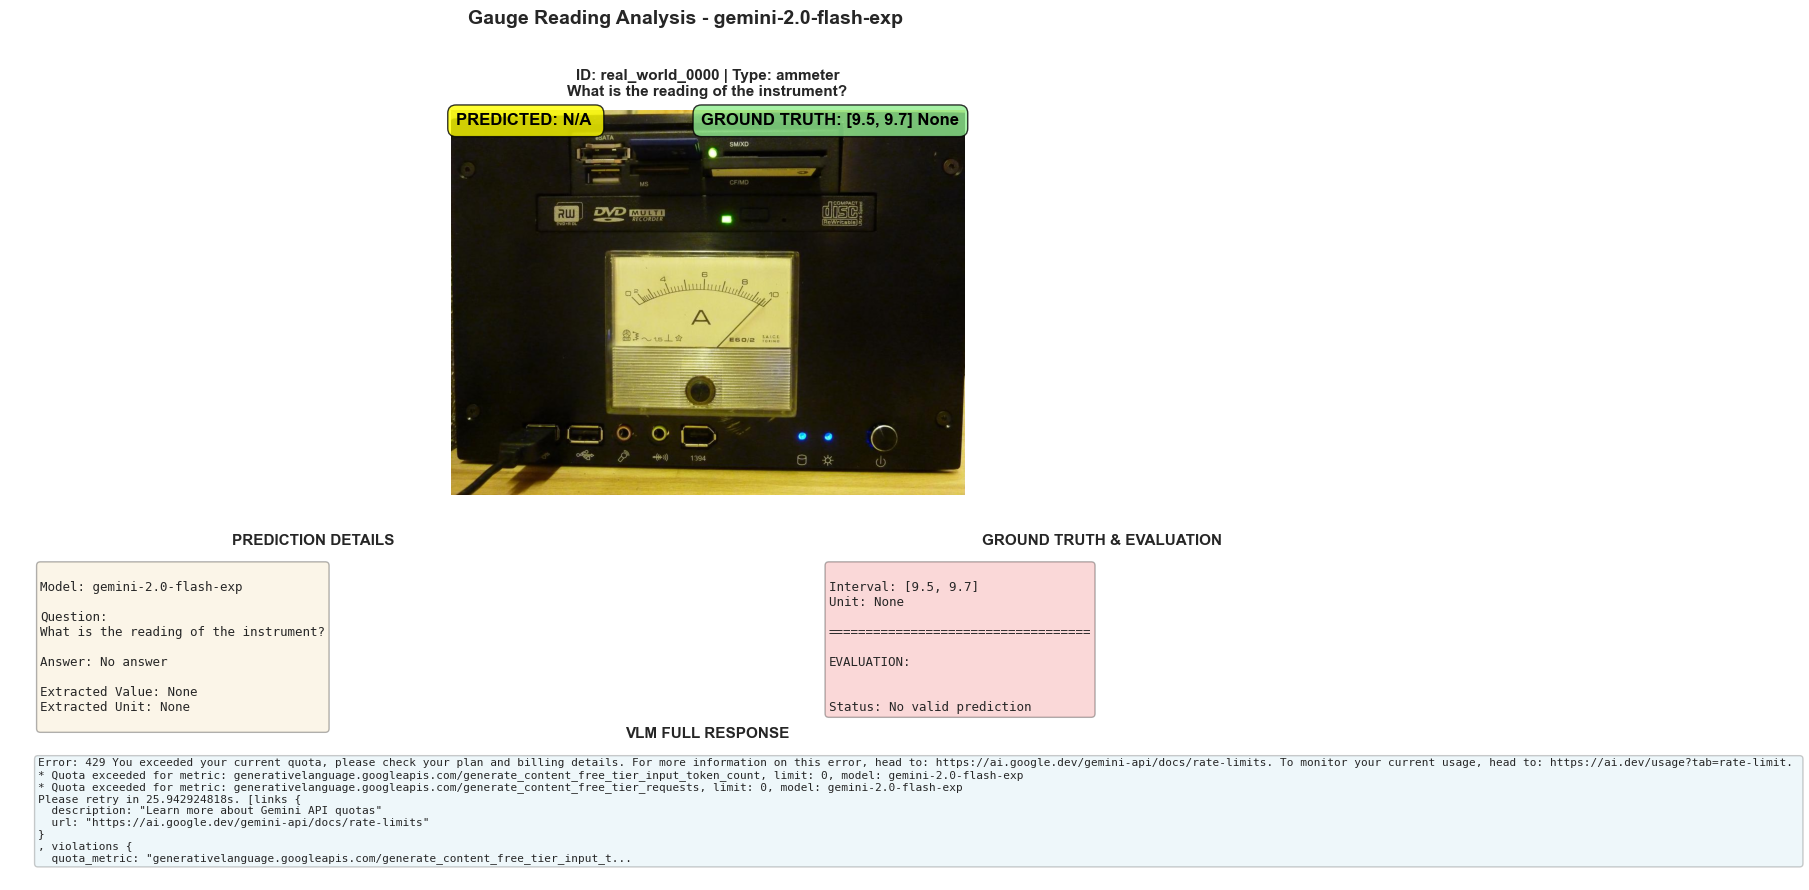

In [5]:
def visualize_single_prediction(prediction, model_name, show_vlm_response=False):
    """Display image with annotations, prediction details, and ground truth"""
    
    question_id = prediction['question_id']
    question = prediction['question']
    image_type = prediction.get('image_type', 'Unknown')
    
    # Get prediction - handle None values
    pred_value = prediction.get('predicted_value')
    pred_unit = prediction.get('predicted_unit')
    pred_answer = prediction.get('prediction')
    vlm_response = prediction.get('vlm_response', '')
    
    # Get ground truth
    gt = prediction.get('ground_truth', {})
    gt_interval = gt.get('interval', [None, None])
    gt_unit = gt.get('unit', 'N/A')
    
    # Load image
    image_path = id_to_image.get(question_id)
    
    # Create visualization layout
    if show_vlm_response:
        fig = plt.figure(figsize=(18, 10))
        gs = fig.add_gridspec(3, 2, height_ratios=[3, 1, 1], hspace=0.3, wspace=0.3)
        ax_img = fig.add_subplot(gs[0, :])
        ax_text = fig.add_subplot(gs[1, 0])
        ax_gt = fig.add_subplot(gs[1, 1])
        ax_response = fig.add_subplot(gs[2, :])
    else:
        fig = plt.figure(figsize=(16, 6))
        gs = fig.add_gridspec(1, 3, width_ratios=[2, 1, 1], wspace=0.3)
        ax_img = fig.add_subplot(gs[0, 0])
        ax_text = fig.add_subplot(gs[0, 1])
        ax_gt = fig.add_subplot(gs[0, 2])
    
    # Display image with annotations
    if image_path and os.path.exists(image_path):
        img = Image.open(image_path)
        ax_img.imshow(img)
        ax_img.axis('off')
        
        # Title with question ID and type
        title = f"ID: {question_id} | Type: {image_type}\n{question}"
        ax_img.set_title(title, fontsize=11, fontweight='bold', pad=10)
        
        # Overlay prediction and ground truth on image
        img_height = img.size[1]
        img_width = img.size[0]
        
        # Prediction box (top-left)
        pred_text = f"PREDICTED: {pred_value if pred_value is not None else 'N/A'} {pred_unit if pred_unit else ''}"
        ax_img.text(10, 30, pred_text, 
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                   fontsize=12, fontweight='bold', color='black')
        
        # Ground truth box (top-right)
        if gt_interval[0] is not None:
            gt_text = f"GROUND TRUTH: [{gt_interval[0]}, {gt_interval[1]}] {gt_unit}"
            ax_img.text(img_width - 10, 30, gt_text, 
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8),
                       fontsize=12, fontweight='bold', color='black',
                       ha='right')
        
        # Correctness indicator (bottom-center)
        if pred_value and gt_interval[0] is not None:
            value_correct = gt_interval[0] <= pred_value <= gt_interval[1]
            unit_correct = (pred_unit.lower() == gt_unit.lower()) if pred_unit and gt_unit else False
            overall_correct = value_correct and unit_correct
            
            status_text = "CORRECT" if overall_correct else "INCORRECT"
            status_color = 'lightgreen' if overall_correct else 'red'
            
            ax_img.text(img_width // 2, img_height - 30, status_text,
                       bbox=dict(boxstyle='round,pad=0.7', facecolor=status_color, alpha=0.9),
                       fontsize=14, fontweight='bold', color='white',
                       ha='center', va='bottom')
    else:
        ax_img.axis('off')
        ax_img.text(0.5, 0.5, f"Image not found\n{question_id}", 
                   ha='center', va='center', fontsize=14, color='red')
    
    # Prediction Details Panel
    ax_text.axis('off')
    ax_text.set_title("PREDICTION DETAILS", fontsize=11, fontweight='bold', pad=10)
    
    # Handle None values safely
    pred_answer_str = str(pred_answer) if pred_answer is not None else 'No answer'
    pred_answer_display = pred_answer_str[:150] + '...' if len(pred_answer_str) > 150 else pred_answer_str
    
    pred_info = f"""
Model: {model_name}

Question:
{question[:100]}{'...' if len(question) > 100 else ''}

Answer: {pred_answer_display}

Extracted Value: {pred_value if pred_value is not None else 'None'}
Extracted Unit: {pred_unit if pred_unit is not None else 'None'}
    """
    
    ax_text.text(0.05, 0.95, pred_info, fontsize=9, family='monospace',
                 verticalalignment='top', transform=ax_text.transAxes,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Ground Truth & Evaluation Panel
    ax_gt.axis('off')
    ax_gt.set_title("GROUND TRUTH & EVALUATION", fontsize=11, fontweight='bold', pad=10)
    
    gt_info = f"""
Interval: [{gt_interval[0]}, {gt_interval[1]}]
Unit: {gt_unit}

{'='*35}

EVALUATION:
    """
    
    if pred_value and gt_interval[0] is not None:
        value_correct = gt_interval[0] <= pred_value <= gt_interval[1]
        unit_correct = (pred_unit.lower() == gt_unit.lower()) if pred_unit and gt_unit else False
        
        # Value check
        if value_correct:
            gt_info += f"\nValue: CORRECT"
        else:
            gt_info += f"\nValue: INCORRECT"
            gt_info += f"\n  Expected: [{gt_interval[0]}, {gt_interval[1]}]"
            gt_info += f"\n  Got: {pred_value}"
        
        # Unit check
        if unit_correct:
            gt_info += f"\n\nUnit: CORRECT"
        else:
            gt_info += f"\n\nUnit: INCORRECT"
            gt_info += f"\n  Expected: {gt_unit}"
            gt_info += f"\n  Got: {pred_unit}"
        
        # Overall
        overall = "PASS" if (value_correct and unit_correct) else "FAIL"
        gt_info += f"\n\n{'='*35}\nOVERALL: {overall}"
    else:
        gt_info += "\n\nStatus: No valid prediction"
    
    color = 'lightgreen' if (pred_value and gt_interval[0] is not None and 
                             gt_interval[0] <= pred_value <= gt_interval[1] and
                             (pred_unit.lower() == gt_unit.lower() if pred_unit and gt_unit else False)) else 'lightcoral'
    
    ax_gt.text(0.05, 0.95, gt_info, fontsize=9, family='monospace',
               verticalalignment='top', transform=ax_gt.transAxes,
               bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
    
    # VLM Full Response (if requested)
    if show_vlm_response and vlm_response:
        ax_response.axis('off')
        ax_response.set_title("VLM FULL RESPONSE", fontsize=11, fontweight='bold', pad=10)
        response_text = vlm_response[:800] + "..." if len(vlm_response) > 800 else vlm_response
        ax_response.text(0.02, 0.95, response_text, fontsize=8, family='monospace',
                        verticalalignment='top', transform=ax_response.transAxes,
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.2))
    
    plt.suptitle(f"Gauge Reading Analysis - {model_name}", fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Test: Visualize first prediction
if all_predictions:
    first_model = list(all_predictions.keys())[0]
    first_pred = all_predictions[first_model][0]
    visualize_single_prediction(first_pred, first_model, show_vlm_response=True)

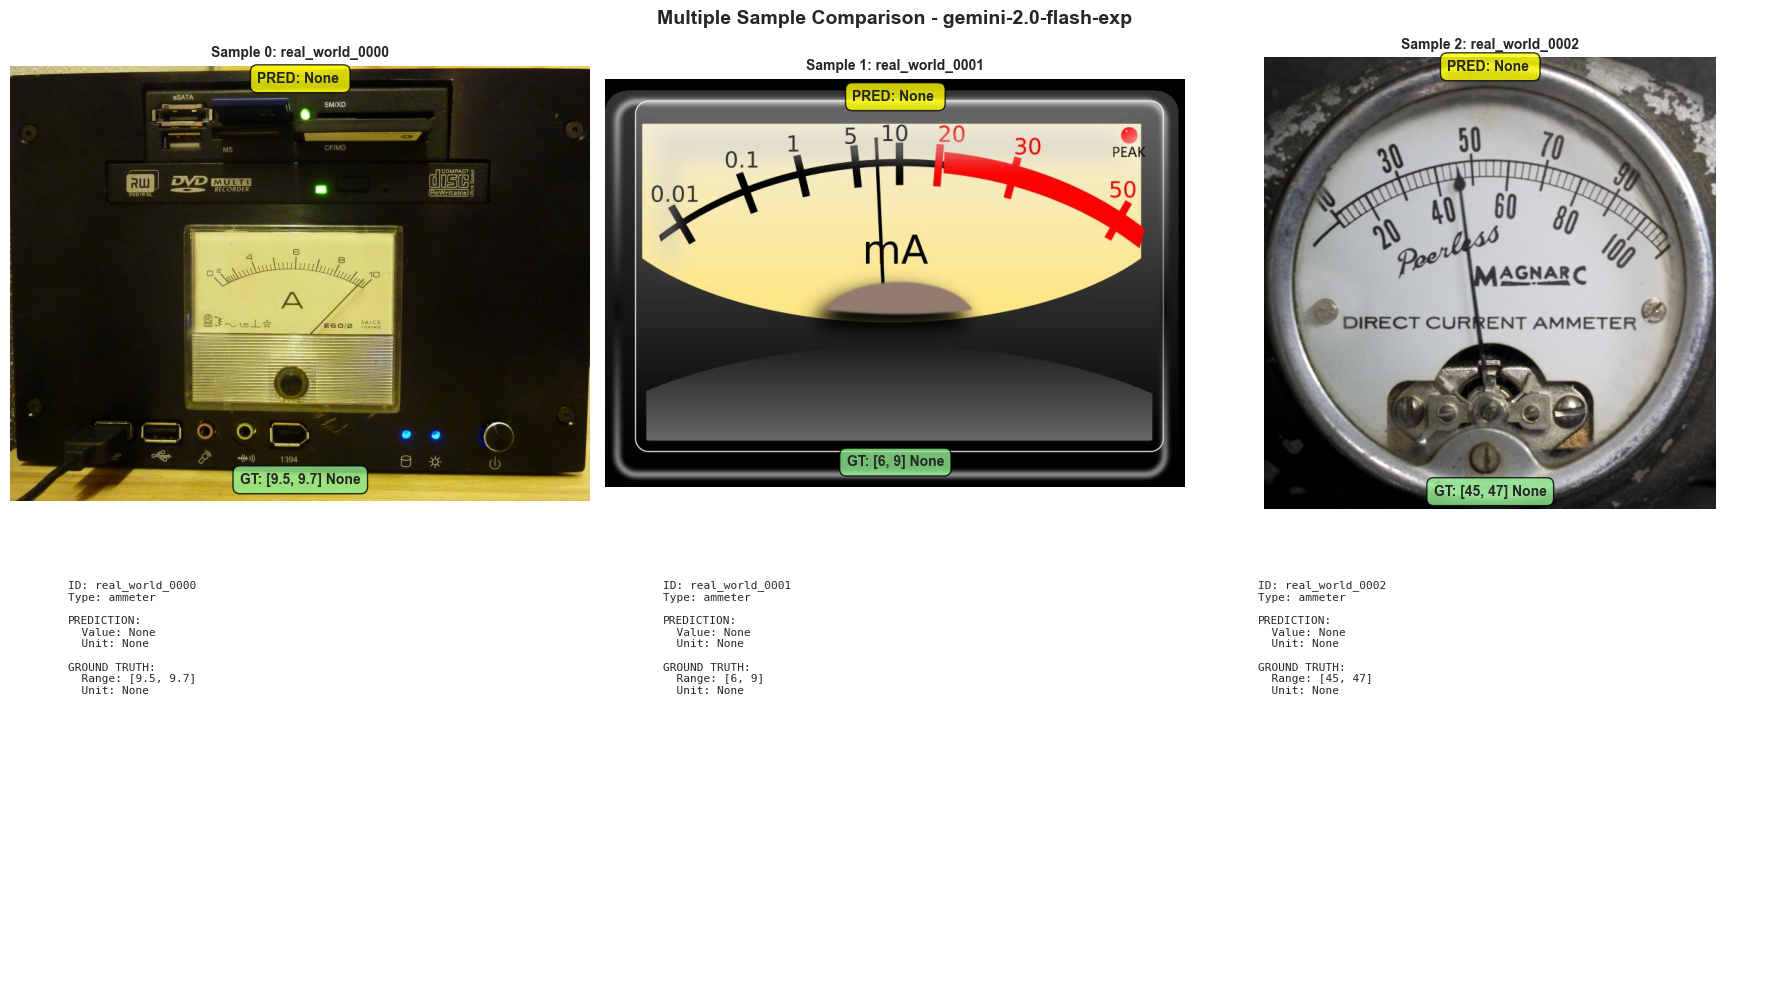

In [6]:
# CELL: Compare multiple samples side-by-side
def visualize_multiple_predictions(predictions, model_name, indices=[0, 1, 2]):
    """Display multiple predictions in a grid"""
    
    n_samples = len(indices)
    fig, axes = plt.subplots(2, n_samples, figsize=(6*n_samples, 10))
    
    if n_samples == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, sample_idx in enumerate(indices):
        if sample_idx >= len(predictions):
            continue
            
        pred = predictions[sample_idx]
        question_id = pred['question_id']
        pred_value = pred.get('predicted_value')
        pred_unit = pred.get('predicted_unit')
        
        gt = pred.get('ground_truth', {})
        gt_interval = gt.get('interval', [None, None])
        gt_unit = gt.get('unit', 'N/A')
        
        # Load and display image
        image_path = id_to_image.get(question_id)
        ax_img = axes[0, idx]
        
        if image_path and os.path.exists(image_path):
            img = Image.open(image_path)
            ax_img.imshow(img)
            ax_img.axis('off')
            
            # Overlay prediction
            img_width, img_height = img.size
            pred_text = f"{pred_value} {pred_unit if pred_unit else ''}"
            ax_img.text(img_width // 2, 30, f"PRED: {pred_text}", 
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                       fontsize=10, fontweight='bold', ha='center')
            
            # Overlay ground truth
            if gt_interval[0] is not None:
                gt_text = f"[{gt_interval[0]}, {gt_interval[1]}] {gt_unit}"
                ax_img.text(img_width // 2, img_height - 30, f"GT: {gt_text}",
                           bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8),
                           fontsize=10, fontweight='bold', ha='center')
            
            # Correctness
            if pred_value and gt_interval[0] is not None:
                correct = (gt_interval[0] <= pred_value <= gt_interval[1] and
                          (pred_unit.lower() == gt_unit.lower() if pred_unit and gt_unit else False))
                status = "CORRECT" if correct else "WRONG"
                color = 'green' if correct else 'red'
                ax_img.text(img_width // 2, img_height // 2, status,
                           bbox=dict(boxstyle='round,pad=1', facecolor=color, alpha=0.7),
                           fontsize=16, fontweight='bold', color='white', ha='center')
            
            ax_img.set_title(f"Sample {sample_idx}: {question_id}", fontsize=10, fontweight='bold')
        
        # Details panel
        ax_text = axes[1, idx]
        ax_text.axis('off')
        
        details = f"""
ID: {question_id}
Type: {pred.get('image_type', 'Unknown')}

PREDICTION:
  Value: {pred_value}
  Unit: {pred_unit}

GROUND TRUTH:
  Range: [{gt_interval[0]}, {gt_interval[1]}]
  Unit: {gt_unit}
        """
        
        if pred_value and gt_interval[0] is not None:
            correct = (gt_interval[0] <= pred_value <= gt_interval[1] and
                      (pred_unit.lower() == gt_unit.lower() if pred_unit and gt_unit else False))
            details += f"\n\nResult: {'PASS' if correct else 'FAIL'}"
        
        ax_text.text(0.1, 0.9, details, fontsize=8, family='monospace',
                    verticalalignment='top', transform=ax_text.transAxes)
    
    plt.suptitle(f"Multiple Sample Comparison - {model_name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example: Compare first 3 samples
if all_predictions:
    first_model = list(all_predictions.keys())[0]
    visualize_multiple_predictions(all_predictions[first_model], first_model, indices=[0, 1, 2])

Available models: ['gemini-2.0-flash-exp', 'gemini-2.5-flash', 'gemini-2.5-pro', 'gemini-3-pro-preview', 'gpt-4o']
Number of samples in gemini-2.0-flash-exp: 5

Visualizing: gemini-2.0-flash-exp, Sample 0



C:\Users\User\AppData\Local\Temp\ipykernel_23368\1996284123.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


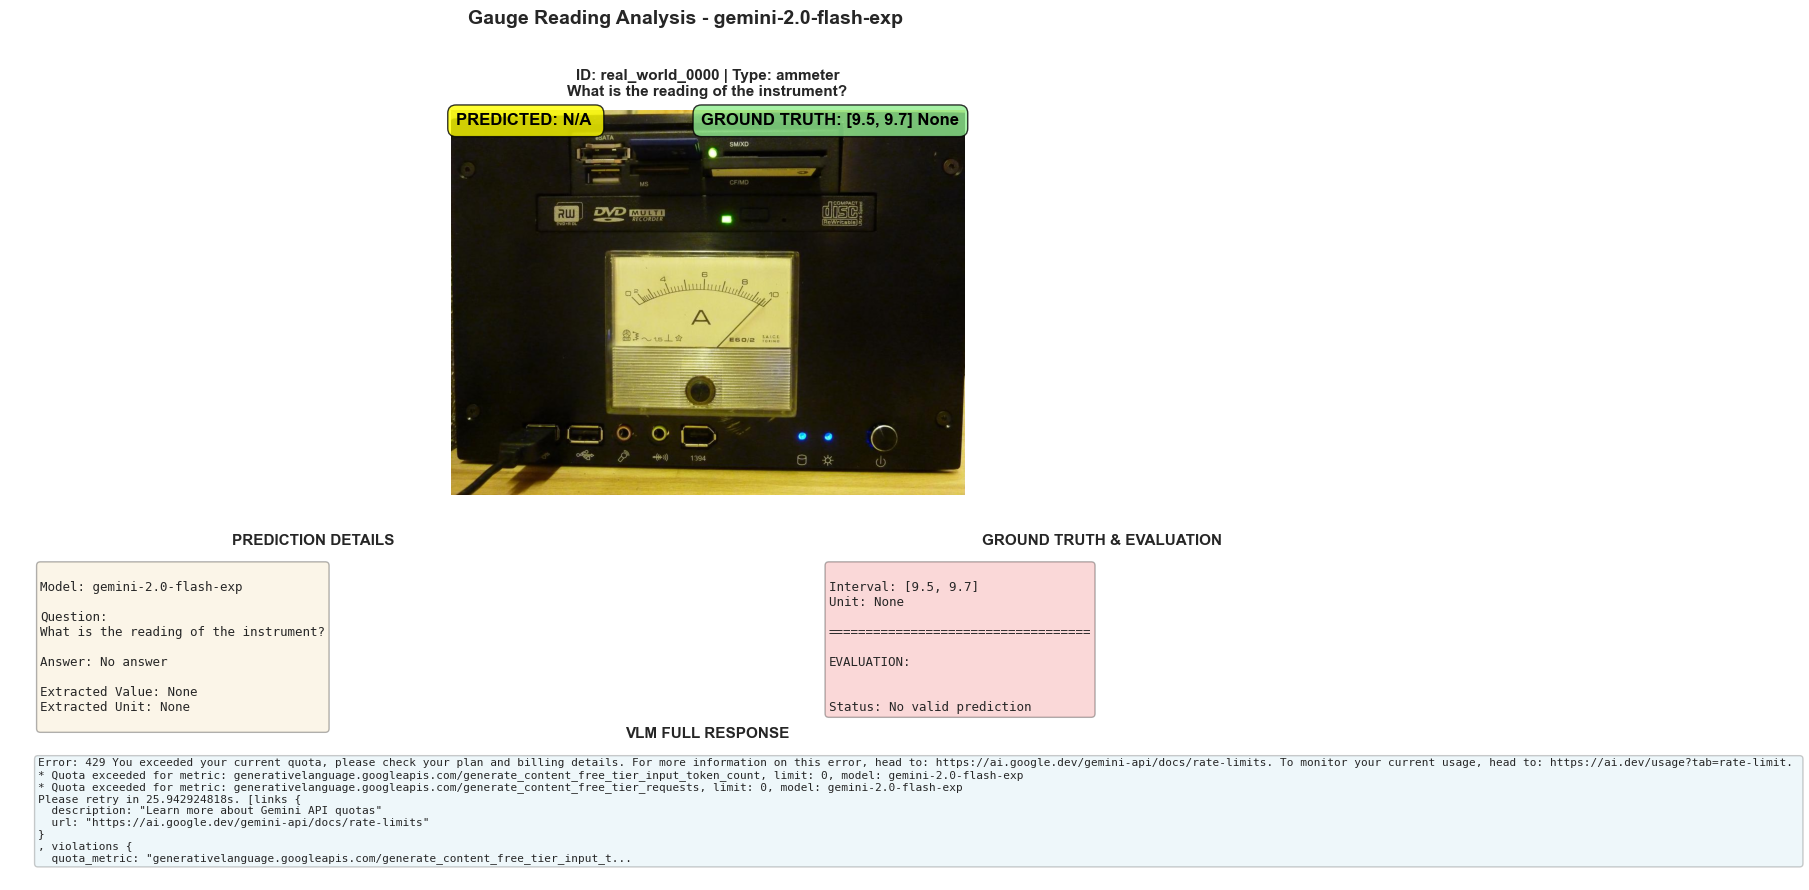

In [7]:
# Select model and sample to visualize
available_models = list(all_predictions.keys())
print(f"Available models: {available_models}")

if available_models:
    model_name = available_models[0]  # Change index to select different model
    sample_idx = 0  # Change this (0 to N-1)
    
    print(f"Number of samples in {model_name}: {len(all_predictions[model_name])}")
    print(f"\nVisualizing: {model_name}, Sample {sample_idx}\n")
    
    visualize_single_prediction(all_predictions[model_name][sample_idx], model_name, show_vlm_response=True)

In [8]:
def calculate_metrics(predictions):
    """Calculate accuracy metrics"""
    total = len(predictions)
    value_correct = 0
    unit_correct = 0
    both_correct = 0
    no_answer = 0
    
    for pred in predictions:
        pred_value = pred.get('predicted_value')
        pred_unit = pred.get('predicted_unit')
        gt = pred.get('ground_truth', {})
        gt_interval = gt.get('interval')
        gt_unit = gt.get('unit')
        
        if pred_value is None:
            no_answer += 1
            continue
            
        if gt_interval and gt_interval[0] is not None:
            if gt_interval[0] <= pred_value <= gt_interval[1]:
                value_correct += 1
        
        if pred_unit and gt_unit:
            if pred_unit.lower() == gt_unit.lower():
                unit_correct += 1
        
        # Check if BOTH are correct
        if gt_interval and pred_unit and gt_unit:
            val_ok = gt_interval[0] <= pred_value <= gt_interval[1]
            unit_ok = pred_unit.lower() == gt_unit.lower()
            if val_ok and unit_ok:
                both_correct += 1
    
    return {
        'total': total,
        'value_correct': value_correct,
        'unit_correct': unit_correct,
        'both_correct': both_correct,
        'no_answer': no_answer,
        'value_accuracy': value_correct / total if total > 0 else 0,
        'unit_accuracy': unit_correct / total if total > 0 else 0,
        'overall_accuracy': both_correct / total if total > 0 else 0
    }

# Calculate metrics for all models
metrics_summary = {}
for model_name, predictions in all_predictions.items():
    metrics_summary[model_name] = calculate_metrics(predictions)

# Display as table
metrics_df = pd.DataFrame(metrics_summary).T
print("\n" + "="*80)
print("PERFORMANCE METRICS")
print("="*80)
print(metrics_df.to_string())
print("="*80)

TypeError: '<=' not supported between instances of 'str' and 'float'

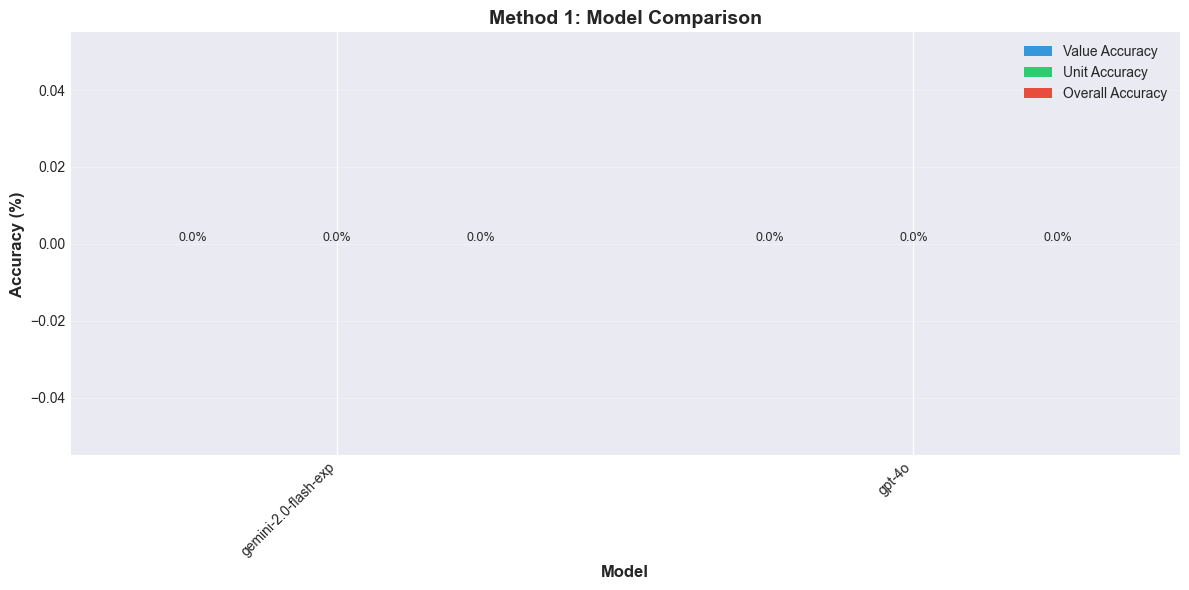


Saved comparison chart to: results/model_comparison.png


In [24]:
if len(all_predictions) > 0:
    # Prepare data for plotting
    models = list(metrics_summary.keys())
    value_acc = [metrics_summary[m]['value_accuracy'] * 100 for m in models]
    unit_acc = [metrics_summary[m]['unit_accuracy'] * 100 for m in models]
    overall_acc = [metrics_summary[m]['overall_accuracy'] * 100 for m in models]
    
    # Create grouped bar chart
    x = range(len(models))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar([i - width for i in x], value_acc, width, label='Value Accuracy', color='#3498db')
    bars2 = ax.bar(x, unit_acc, width, label='Unit Accuracy', color='#2ecc71')
    bars3 = ax.bar([i + width for i in x], overall_acc, width, label='Overall Accuracy', color='#e74c3c')
    
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Method 1: Model Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)
    
    plt.tight_layout()
    plt.savefig('results/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\nSaved comparison chart to: results/model_comparison.png")

In [25]:
def analyze_by_type(predictions):
    """Group predictions by instrument type and calculate accuracy"""
    by_type = {}
    
    for pred in predictions:
        img_type = pred.get('image_type', 'Unknown')
        if img_type not in by_type:
            by_type[img_type] = []
        by_type[img_type].append(pred)
    
    type_metrics = {}
    for img_type, preds in by_type.items():
        type_metrics[img_type] = calculate_metrics(preds)
    
    return type_metrics

# Analyze for each model
for model_name, predictions in all_predictions.items():
    print(f"\n{'='*60}")
    print(f"MODEL: {model_name}")
    print(f"{'='*60}")
    
    type_metrics = analyze_by_type(predictions)
    type_df = pd.DataFrame(type_metrics).T
    print(type_df[['total', 'value_accuracy', 'unit_accuracy', 'overall_accuracy']].to_string())


MODEL: gemini-2.0-flash-exp
         total  value_accuracy  unit_accuracy  overall_accuracy
ammeter    5.0             0.0            0.0               0.0

MODEL: gpt-4o
         total  value_accuracy  unit_accuracy  overall_accuracy
ammeter    1.0             0.0            0.0               0.0


In [26]:
# Create comprehensive summary report
summary_report = {
    'overall_metrics': metrics_summary,
    'per_model_breakdown': {}
}

for model_name, predictions in all_predictions.items():
    summary_report['per_model_breakdown'][model_name] = {
        'total_samples': len(predictions),
        'metrics': metrics_summary[model_name],
        'by_instrument_type': analyze_by_type(predictions)
    }

# Save to JSON
with open('results/summary_report.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print("Saved summary report to: results/summary_report.json")

# Also save metrics as CSV
metrics_df.to_csv('results/metrics_summary.csv')
print("Saved metrics CSV to: results/metrics_summary.csv")

Saved summary report to: results/summary_report.json
Saved metrics CSV to: results/metrics_summary.csv


## For one image 


In [15]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import os
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Imports successful!")

Imports successful!


In [44]:
def load_predictions(prediction_file):
    """Load predictions from JSON file"""
    with open(prediction_file, 'r') as f:
        data = json.load(f)
    return data

# Load available prediction files
results_dir = Path("results")
prediction_files = list(results_dir.glob("*_predictions.json"))

print(f"Found {len(prediction_files)} prediction files:")
for f in prediction_files:
    print(f"  - {f.name}")

# Load all predictions
all_predictions = {}
for pred_file in prediction_files:
    model_name = pred_file.stem.replace('_predictions', '')
    all_predictions[model_name] = load_predictions(pred_file)
    print(f"\nLoaded {len(all_predictions[model_name])} predictions for {model_name}")

Found 3 prediction files:
  - gemini-2.0-flash-exp_predictions.json
  - gemini-2.5-flash_predictions.json
  - gpt-4o_predictions.json

Loaded 5 predictions for gemini-2.0-flash-exp

Loaded 17 predictions for gemini-2.5-flash

Loaded 1 predictions for gpt-4o


C:\Users\User\AppData\Local\Temp\ipykernel_27292\2476395095.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


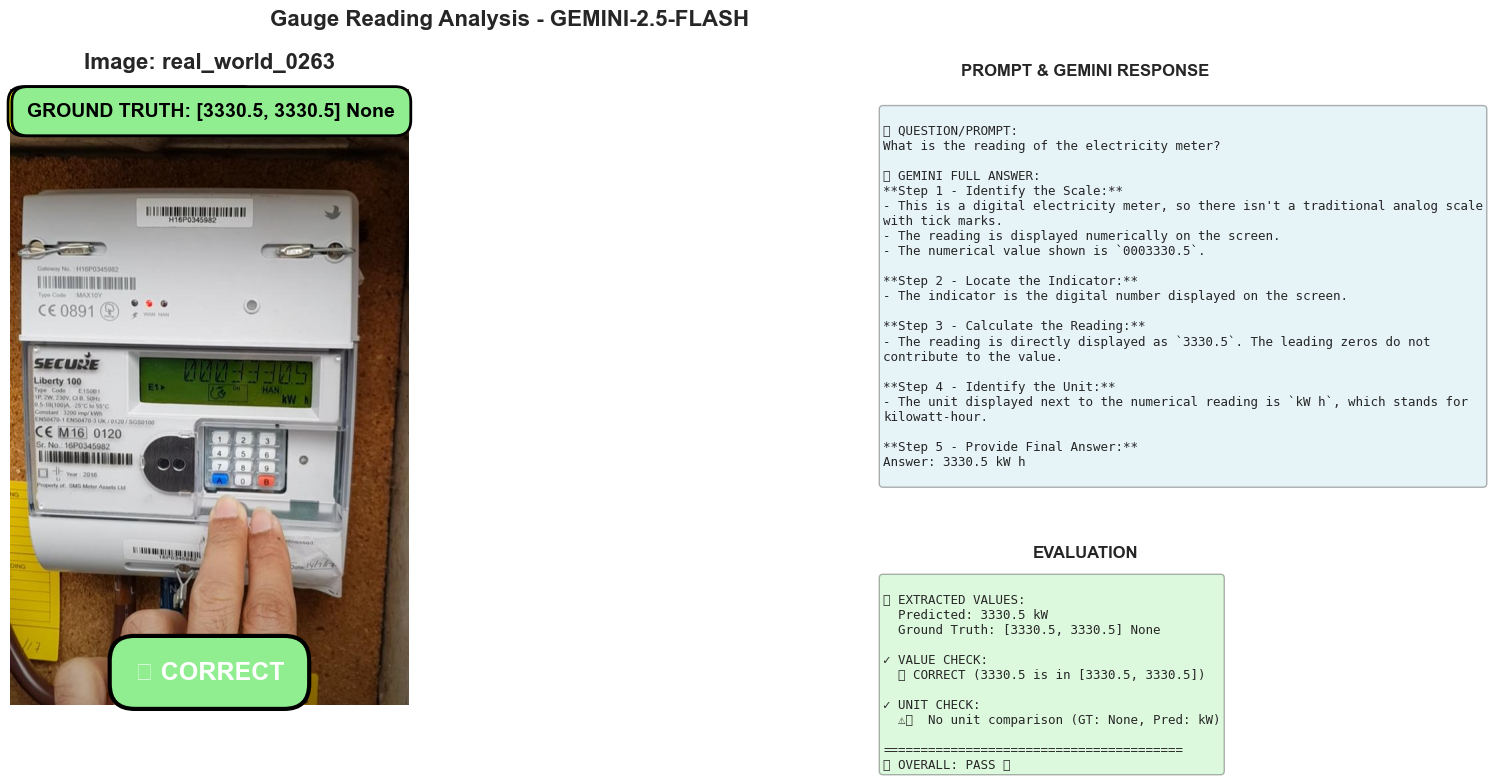


✅ Visualization complete for real_world_0263


In [45]:
# Simple visualization for single image with full details
import json
import matplotlib.pyplot as plt
from PIL import Image
import os

def visualize_prediction_simple(image_id, model_name='gemini-2.5-flash'):
    """Simple, clean visualization with image, prompt, and prediction"""
    
    # Find prediction
    pred = None
    for p in all_predictions[model_name]:
        if p['question_id'] == image_id:
            pred = p
            break
    
    if not pred:
        print(f"❌ No prediction found for {image_id}")
        return
    
    # Get data
    pred_value = pred.get('predicted_value')
    pred_unit = pred.get('predicted_unit', '')
    full_answer = pred.get('prediction', '')
    question = pred.get('question', '')
    
    gt = pred.get('ground_truth', {})
    gt_interval = gt.get('interval', [None, None])
    gt_unit = gt.get('unit', '')
    
    # Load image
    image_path = id_to_image.get(image_id)
    
    # Create figure with 3 parts: Image | Prompt & Answer | Evaluation
    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[2, 1], hspace=0.3, wspace=0.3)
    
    # ====== LEFT: IMAGE ======
    ax_img = fig.add_subplot(gs[:, 0])
    
    if image_path and os.path.exists(image_path):
        img = Image.open(image_path)
        ax_img.imshow(img)
        ax_img.axis('off')
        
        img_width, img_height = img.size
        
        # Prediction box (yellow, top-left)
        pred_text = f"PREDICTED: {pred_value} {pred_unit}"
        ax_img.text(20, 40, pred_text, 
                   bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow', edgecolor='black', linewidth=2),
                   fontsize=14, fontweight='bold', color='black')
        
        # Ground truth box (green, top-right)
        if gt_interval[0] is not None:
            gt_text = f"GROUND TRUTH: [{gt_interval[0]}, {gt_interval[1]}] {gt_unit}"
            ax_img.text(img_width - 20, 40, gt_text, 
                       bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgreen', edgecolor='black', linewidth=2),
                       fontsize=14, fontweight='bold', color='black', ha='right')
        
        # Correctness status (bottom center)
        if pred_value is not None and gt_interval[0] is not None:
            value_ok = gt_interval[0] <= pred_value <= gt_interval[1]
            unit_ok = (pred_unit.lower() == gt_unit.lower()) if (pred_unit and gt_unit) else True
            is_correct = value_ok and unit_ok
            
            status = "✓ CORRECT" if is_correct else "✗ INCORRECT"
            color = 'lightgreen' if is_correct else 'red'
            
            ax_img.text(img_width // 2, img_height - 40, status,
                       bbox=dict(boxstyle='round,pad=1', facecolor=color, edgecolor='black', linewidth=3),
                       fontsize=18, fontweight='bold', color='white', ha='center')
        
        ax_img.set_title(f"Image: {image_id}", fontsize=16, fontweight='bold', pad=15)
    
    # ====== TOP-RIGHT: PROMPT & ANSWER ======
    ax_prompt = fig.add_subplot(gs[0, 1])
    ax_prompt.axis('off')
    ax_prompt.set_title("PROMPT & GEMINI RESPONSE", fontsize=12, fontweight='bold', pad=10)
    
    prompt_text = f"""
📝 QUESTION/PROMPT:
{question}

🤖 GEMINI FULL ANSWER:
{full_answer}
    """
    
    ax_prompt.text(0.05, 0.95, prompt_text, fontsize=9, family='monospace',
                   verticalalignment='top', transform=ax_prompt.transAxes,
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3),
                   wrap=True)
    
    # ====== BOTTOM-RIGHT: EVALUATION ======
    ax_eval = fig.add_subplot(gs[1, 1])
    ax_eval.axis('off')
    ax_eval.set_title("EVALUATION", fontsize=12, fontweight='bold', pad=10)
    
    eval_text = f"""
📊 EXTRACTED VALUES:
  Predicted: {pred_value} {pred_unit}
  Ground Truth: [{gt_interval[0]}, {gt_interval[1]}] {gt_unit}

✓ VALUE CHECK:
"""
    
    if pred_value is not None and gt_interval[0] is not None:
        value_ok = gt_interval[0] <= pred_value <= gt_interval[1]
        if value_ok:
            eval_text += f"  ✅ CORRECT ({pred_value} is in [{gt_interval[0]}, {gt_interval[1]}])"
        else:
            eval_text += f"  ❌ WRONG ({pred_value} NOT in [{gt_interval[0]}, {gt_interval[1]}])"
        
        eval_text += f"\n\n✓ UNIT CHECK:\n"
        if pred_unit and gt_unit:
            unit_ok = pred_unit.lower() == gt_unit.lower()
            if unit_ok:
                eval_text += f"  ✅ CORRECT ('{pred_unit}' matches '{gt_unit}')"
            else:
                eval_text += f"  ❌ WRONG ('{pred_unit}' ≠ '{gt_unit}')"
        else:
            eval_text += f"  ⚠️  No unit comparison (GT: {gt_unit}, Pred: {pred_unit})"
        
        # Overall
        both_ok = value_ok and (unit_ok if (pred_unit and gt_unit) else True)
        eval_text += f"\n\n{'='*40}\n"
        eval_text += f"🎯 OVERALL: {'PASS ✅' if both_ok else 'FAIL ❌'}"
    else:
        eval_text += "  ⚠️  Cannot evaluate (missing data)"
    
    bg_color = 'lightgreen' if (pred_value and gt_interval[0] and 
                                 gt_interval[0] <= pred_value <= gt_interval[1]) else 'lightcoral'
    
    ax_eval.text(0.05, 0.95, eval_text, fontsize=9, family='monospace',
                 verticalalignment='top', transform=ax_eval.transAxes,
                 bbox=dict(boxstyle='round', facecolor=bg_color, alpha=0.3))
    
    plt.suptitle(f"Gauge Reading Analysis - {model_name.upper()}", 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print(f"✅ Visualization complete for {image_id}")
    print("="*80)


# ====== RUN IT! ======
visualize_prediction_simple('real_world_0263', model_name='gemini-2.5-flash')